In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import jax.numpy as jnp

from utils import manifold, metrics
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

In [2]:
def preprocess(data, scaler):
    data = data.reshape(*data.shape[:-1], 2, data.shape[-1] // 2).swapaxes(-2, -1).reshape(data.shape)
    scaled_data = scaler().fit_transform(data.reshape(-1, 2)).reshape(data.shape)
    return scaled_data, data

file_name = "turing_400_200_50_l8.0"
out_name = file_name
raw_data = np.load("data/" + file_name + ".npz")
raw_data, params = raw_data["data"], raw_data["params"]

eta = params[:,0]
data, raw_data = preprocess(raw_data, MaxAbsScaler)

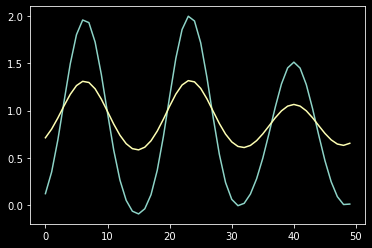

In [3]:
plt.plot(raw_data[0,0,:].reshape(50,2));

CPU times: user 5min 3s, sys: 1min 56s, total: 7min
Wall time: 54 s
Converged? True
[]


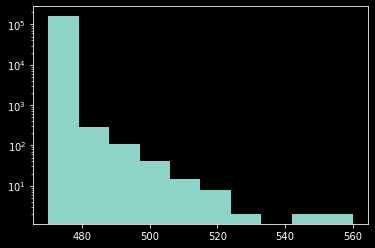

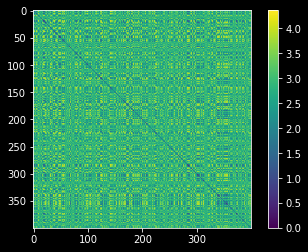

In [4]:
%time dist_mat, converged, steps = metrics.distance_matrix(data, mesh_shape=(4,2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1-converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)

plt.figure()
plt.imshow(dist_mat)
plt.colorbar();

In [3]:
# np.savez(out_name + "_dist_mat.npz", dist_mat=dist_mat)
dist_mat = np.load(out_name + "_dist_mat.npz")['dist_mat']

In [4]:
evals, embedding, epsilon = manifold.diffusion_map(dist_mat, n_components=20, epsilon='max', n_neighbors=20, alpha=1, robust=True)

nn_max = 1.347454309463501
epsilon = 3.6312662321835205
mean_shift = 0.012344314


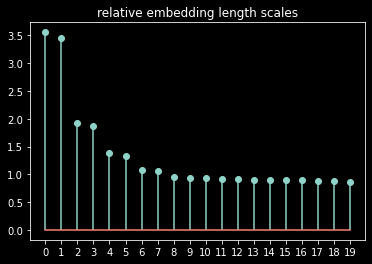

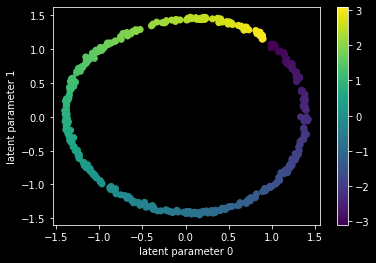

In [5]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon/np.log(1+evals)), use_line_collection=True)
plt.title('relative embedding length scales')
plt.xticks(ticks=range(evals.shape[0]))

plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], c=eta)
plt.xlabel("latent parameter 0")
plt.ylabel("latent parameter 1")
plt.colorbar();

[0, 1]


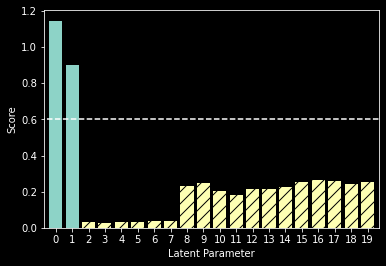

In [6]:
threshold = 0.6
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="adjusted")
print(embed_list)

plt.bar(list(range(n_components)), scores_pass)
plt.bar(list(range(n_components)), scores_fail, hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

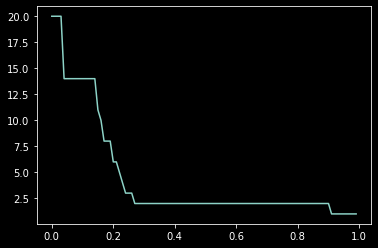

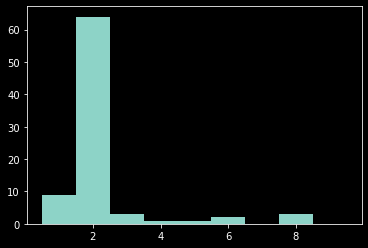

In [34]:
embedding_size_list = []
for thres in np.arange(0.0, 1., 0.01):
    embedding_size_list.append(len(manifold.heuristic_importance_score(evals, embedding, threshold=thres, weights="adjusted")[0]))

plt.figure()
plt.plot(np.arange(0.0, 1., 0.01), embedding_size_list)
plt.figure()
plt.hist(embedding_size_list, bins=np.arange(10)+0.5);

R^2 = 0.9991285627531686
Coefficent(s): [-0.47964567 -0.5174526 ]
SpearmanrResult(correlation=0.9993218082613015, pvalue=0.0)
R^2 = 0.9996848952438927
Coefficent(s): [-0.5298501   0.46908557]
SpearmanrResult(correlation=0.9992344327152044, pvalue=0.0)


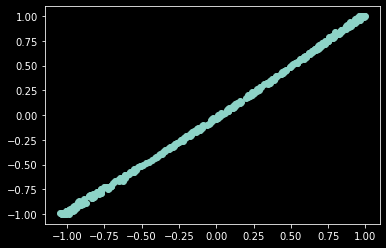

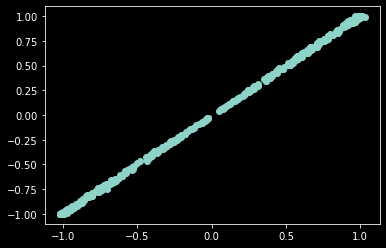

In [28]:
from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]
y = np.cos(eta)
reg = LinearRegression().fit(X, y)
print("R^2 =", reg.score(X, y))
print("Coefficent(s):", reg.coef_)

from scipy.stats import spearmanr
print(spearmanr(reg.predict(X), y))

plt.figure()
plt.scatter(reg.predict(X), y);

from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]
y = np.sin(eta)
reg = LinearRegression().fit(X, y)
print("R^2 =", reg.score(X, y))
print("Coefficent(s):", reg.coef_)

from scipy.stats import spearmanr
print(spearmanr(reg.predict(X), y))

plt.figure()
plt.scatter(reg.predict(X), y);

turing_400_200_50_l8.0


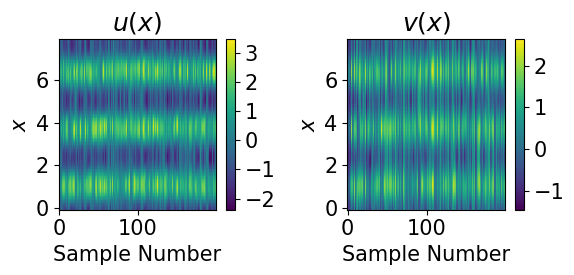

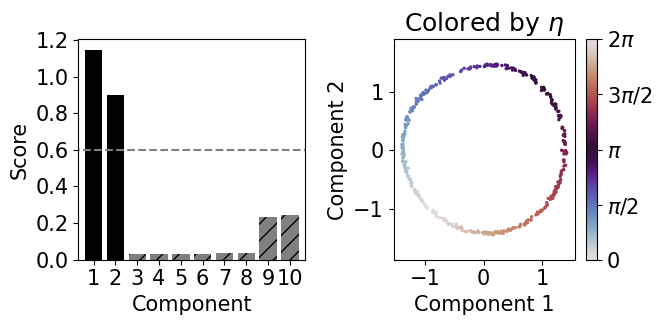

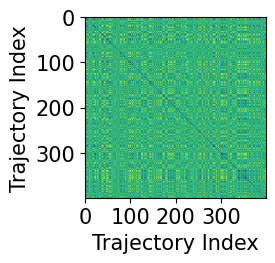

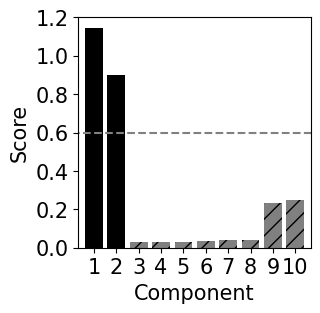

In [27]:
print(out_name)
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(raw_data[0,:,::2].T, aspect='auto', origin='lower')
    plt.xlabel('Sample Number')
    plt.ylabel('$x$')
    plt.yticks([0,12.5, 25, 37.5],[0, 2, 4, 6])
    plt.colorbar()
    plt.title("$u(x)$")

    plt.subplot(122)
    plt.imshow(raw_data[0,:,1::2].T, aspect='auto', origin='lower')
    plt.xlabel('Sample Number')
    plt.ylabel('$x$')
    plt.yticks([0,12.5, 25, 37.5],[0, 2, 4, 6])
    plt.colorbar()
    plt.title("$v(x)$")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_data.pdf", bbox_inches="tight")

    # plt.figure(figsize=(3.5,3))
    plt.figure(figsize=(7,3.5))
    plt.subplot(121)
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Component")
    plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")

    plt.subplot(122)
    plt.scatter(embedding[:,0], embedding[:,1], c=np.mod(eta, 2*np.pi), s=2, cmap='twilight', vmin=0, vmax=2*np.pi)
    cbar = plt.colorbar(ticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    cbar.ax.set_yticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']) 
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("Colored by $\eta$")
    plt.axis('equal')

    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_embedding.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.imshow(dist_mat)
    plt.xlabel("Trajectory Index")
    plt.ylabel("Trajectory Index")
    plt.tight_layout()

    plt.savefig(f"figures/{out_name}_dist_mat.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Component")
    plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")
    plt.savefig(f"figures/{out_name}_score.pdf", bbox_inches="tight")
